# ResNet 34 model for Plant Seedlings Classification #

### Imports ###

In [1]:
import os

import torch
from torch import nn
from torch import optim # Model optimizer
from torch.utils.data import Dataset, DataLoader, sampler # Data loading
from torch.autograd import Variable

import torchvision
from torchvision import transforms # Data augmentation
from torchvision.datasets.folder import ImageFolder # Dataset
from torchvision import models # Resnet34 Model

import torchsample # Torchsample is installed from https://github.com/YannDubs/torchsample fork
from torchsample.regularizers import L1Regularizer, L2Regularizer
from torchsample.modules.module_trainer import ModuleTrainer # Training the model
from torchsample.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger # Model supervising
from torchsample.metrics import CategoricalAccuracy # Accuracy criterion

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

from sklearn.metrics import confusion_matrix # Confusion Matrix

import pandas as pd # For test submission

from PIL import Image # Test dataset image opening

c:\users\aty\anaconda3\envs\tf5\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
USE_CUDA = torch.cuda.is_available()
BATCH_SIZE = 50

## Train and Validation data loading ##

### Data Augmentation ###

Augment only the images of training dataset with random 
* Rotations
* Horizontal / vertical flips
* Changes to brightness, contrast, saturation and hue
* Grayscale conversion

In [3]:
training_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.RandomRotation(degrees=60),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                                         transforms.RandomGrayscale(0.1),
                                         transforms.ToTensor()])

In [4]:
validation_transform = transforms.Compose([transforms.Resize((224, 224)),
                                           transforms.ToTensor()])

### Loading the training dataset ###

In [5]:
training_dataset = ImageFolder('data/train', transform=training_transform)
validation_dataset = ImageFolder('data/train', transform=validation_transform)

In [6]:
training_dataset.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [7]:
num_classes = len(training_dataset.classes)

In [8]:
assert(training_dataset.class_to_idx == validation_dataset.class_to_idx)

### Training - Validation Split ###

In [9]:
TRAINING_SIZE = int(len(training_dataset) * 0.8)

In [10]:
indices = torch.randperm(len(training_dataset))

In [11]:
training_indices = indices[:TRAINING_SIZE]
validation_indices = indices[TRAINING_SIZE:]

In [12]:
training_sampler = sampler.SubsetRandomSampler(training_indices)
test_sampler = sampler.SubsetRandomSampler(validation_indices)

In [13]:
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, sampler=training_sampler)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

### Visualizing validation and augmented training samples ###

In [14]:
from itertools import islice
from operator import itemgetter

def take_n_images(dataset, indices, specie_idx, nr_images=10):
    images = filter(lambda x: x[1] == specie_idx, map(lambda idx: dataset[idx], indices))
    images = islice(images, nr_images)
    return list(map(itemgetter(0), images))

In [15]:
def plot_images(dataset, indices, nr_images=11, title=''):
    images_per_class = [take_n_images(dataset, indices, i, nr_images) for i in range(len(dataset.classes))]
    fig = plt.figure(1, (15., 15.))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(12, 12), 
                     axes_pad=0.1,
                     )
    i = 0
    for class_idx, images in enumerate(images_per_class):
        for image in images:
            grid[i].imshow(image.permute(2,1,0).numpy())
            grid[i].set_xticks([])
            grid[i].set_yticks([])
            i += 1
        grid[i].text(0, 112, dataset.classes[class_idx])
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        i += 1
    
    plt.title(title)
    plt.show()

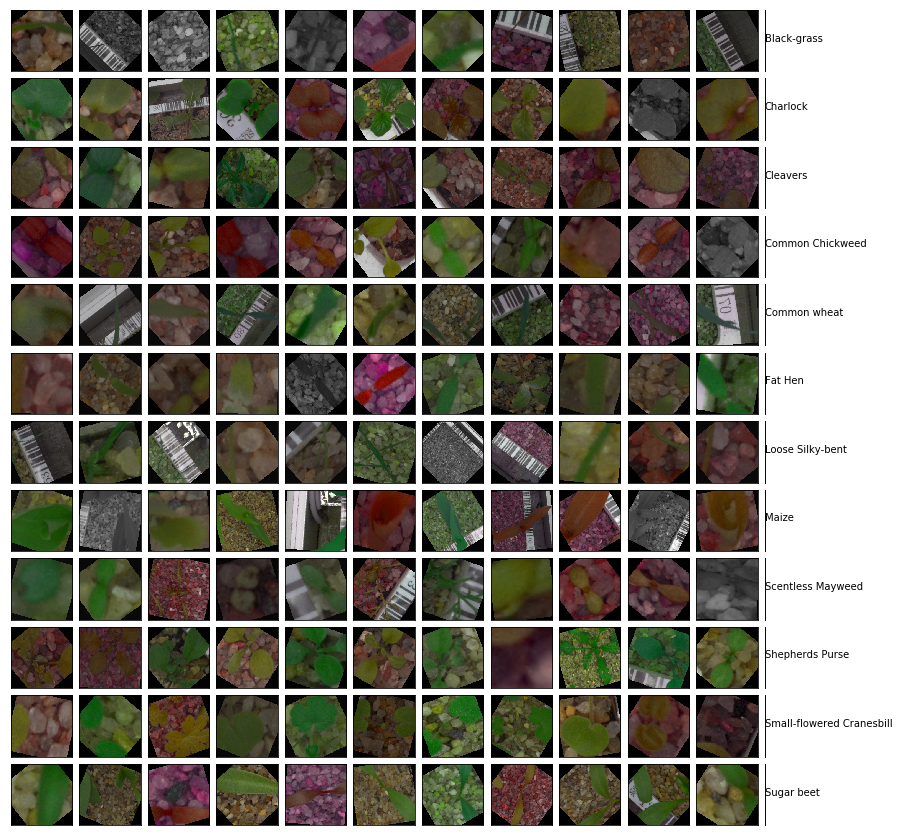

In [16]:
plot_images(training_dataset, training_indices, title='Training samples')

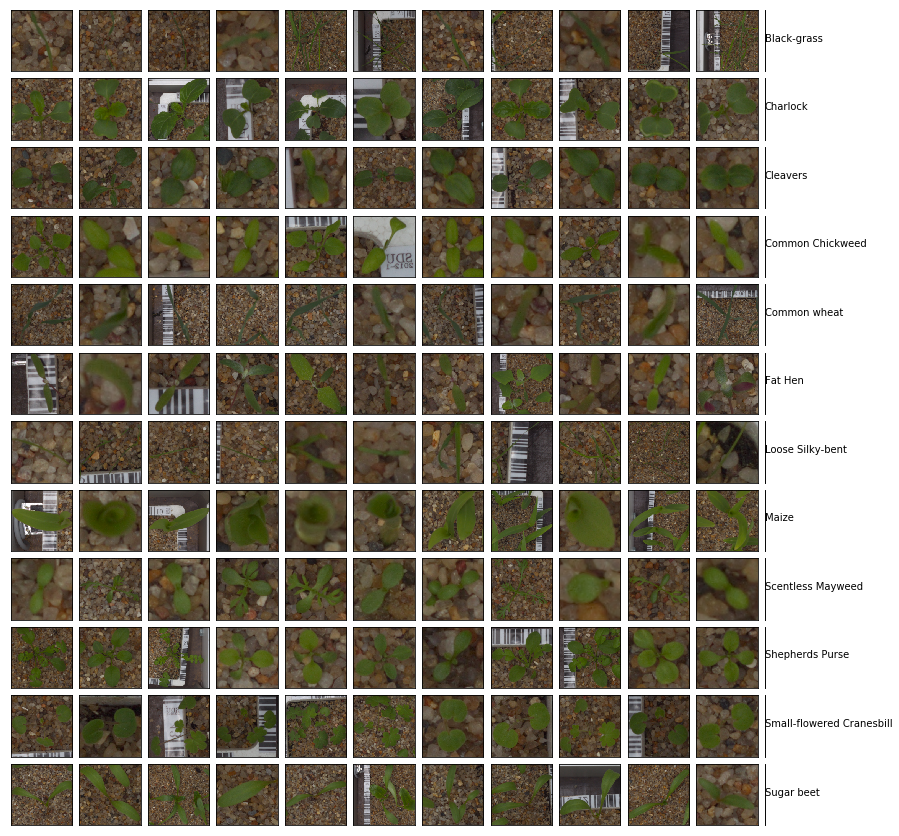

In [17]:
plot_images(validation_dataset, validation_indices, title='Training samples')

## Model Definition ##

### ResNet-34 ###

![ResNet Architecture](img/resNet.jpeg)

In [18]:
model = models.resnet34(pretrained=True)

In [19]:
model

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

For adapt `resnet34` model to plant seedlings classification it's necessary to change the last fully connected layer (of 1000 outputs) to one with 12 (one for each plant specie)

In [20]:
model.fc = nn.Linear(in_features=512, out_features=12, bias=True)

Turn the model to cuda if wanted to train on GPU

In [21]:
if USE_CUDA:
    model.cuda()

## Training Phase ##

### Optimizer & Regularizers ###

In [22]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

Regularization techniques applied are:
* L1 Regularization for convolutional layers to encourage sparsity
* L2 Regularization for the last fully connected layer
* Reduce learning rate if validation loss does not improve after 5 epochs

In [23]:
regularizers = [L1Regularizer(scale=1e-5, module_filter='*conv*'),
                L2Regularizer(scale=1e-5, module_filter='fc')]

In [24]:
callbacks = [ReduceLROnPlateau(factor=0.5, patience=5),
             ModelCheckpoint(directory='weights'),
             CSVLogger('stats.csv')]
metrics = [CategoricalAccuracy(top_k=1)]

In [25]:
trainer = ModuleTrainer(model)

In [26]:
trainer.compile(loss=nn.CrossEntropyLoss(),
                optimizer=optimizer,
                metrics=metrics,
                regularizers=regularizers,
                callbacks=callbacks)

In [27]:
trainer.fit_loader(training_loader,
                   validation_loader,
                   num_epoch=30,
                   verbose=1,
                   cuda_device=0 if USE_CUDA else -1)

Epoch 1/30: : 77 batches [02:31,  9.04s/ batches, loss=3.48, acc=47.63, reg_loss=2.42, lr=[0.01], val_acc=67.79, val_loss=0.854]       
Epoch 2/30: : 77 batches [02:26,  8.31s/ batches, loss=3.12, acc=69.95, reg_loss=2.41, lr=[0.01], val_acc=67.26, val_loss=1.34]       
Epoch 3/30: : 77 batches [02:15,  6.44s/ batches, loss=2.86, acc=74.29, reg_loss=2.4, lr=[0.01], val_acc=82.95, val_loss=0.516]       
Epoch 4/30: : 77 batches [02:12,  6.41s/ batches, loss=2.98, acc=74.50, reg_loss=2.38, lr=[0.01], val_acc=83.58, val_loss=0.445]       
Epoch 5/30: : 77 batches [02:14,  6.49s/ batches, loss=2.88, acc=79.79, reg_loss=2.36, lr=[0.01], val_acc=87.16, val_loss=0.349]       
Epoch 6/30: : 77 batches [02:15,  6.59s/ batches, loss=2.97, acc=79.13, reg_loss=2.35, lr=[0.01], val_acc=89.89, val_loss=0.271]       
Epoch 7/30: : 77 batches [02:16,  6.68s/ batches, loss=3.21, acc=79.53, reg_loss=2.33, lr=[0.01], val_acc=85.47, val_loss=0.399]       
Epoch 8/30: : 77 batches [02:24,  8.20s/ batches, 

## Evaluation ##

In [28]:
stats = pd.read_csv('stats.csv')

### Loss ###

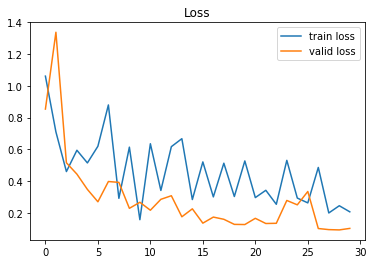

In [40]:
plt.plot(stats['loss']-stats['reg_loss'], label='train loss')
plt.plot(stats['val_loss'], label='valid loss')
plt.legend()
plt.title('Loss')
plt.show()

### Accuraccy ###

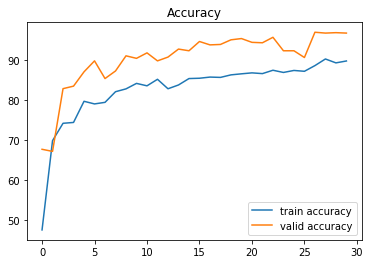

In [30]:
plt.plot(stats['acc_metric'], label='train accuracy')
plt.plot(stats['val_acc_metric'], label='valid accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

### Confusion Matrix ###

From [scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) of confusion matrix. The cell $C_{i,j}$ of the confusion matrix means the number of observations known to be labeled with `i` but predicted with label `j`.

In [31]:
def predict(x):
    if USE_CUDA:
        x = x.cuda()
    x = Variable(x)
    idxs = model(x).topk(1)[1].data
    return [validation_dataset.classes[idx[0]] for idx in idxs]

In [32]:
labels = []
targets = []
for i, (tensor, target) in enumerate(validation_loader):
    p = predict(tensor)
    labels.extend(p)
    targets.extend([validation_dataset.classes[t] for t in target])
conf_matrix = confusion_matrix(targets, labels, labels=validation_dataset.classes)

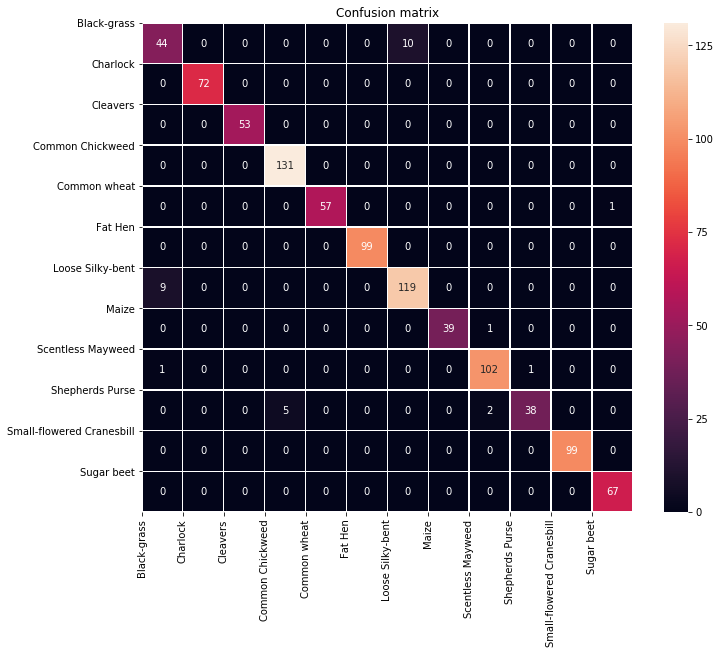

In [33]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion matrix")
plt.xticks(range(num_classes), validation_dataset.classes, rotation='vertical')
plt.yticks(range(num_classes), validation_dataset.classes, rotation='horizontal')
plt.show()

## Test Submission ##

In [34]:
class TestPlantsDataset(Dataset):
    def __init__(self, root, transform=None):
        super(TestPlantsDataset, self).__init__()
        self.root = root
        self.transform = transform
        self.images_names = sorted(os.listdir(self.root))

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        image_name = self.images_names[idx]
        image = Image.open(os.path.join(self.root, image_name))
        if self.transform:
            image = self.transform(image)
        return image

In [35]:
test_dataset = TestPlantsDataset('data/test/', transform=validation_transform)

In [36]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [37]:
names = test_dataset.images_names
species = []
for x in test_loader:
    species.extend(predict(x))

df = pd.DataFrame({'file' : names, 'species' : species})

In [38]:
df

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet
5,00d090cde.png,Loose Silky-bent
6,00ef713a8.png,Common Chickweed
7,01291174f.png,Fat Hen
8,026716f9b.png,Loose Silky-bent
9,02cfeb38d.png,Loose Silky-bent


In [39]:
df.to_csv('submission.csv', index=False)